* Write a new code, using relevant parts of the MC tutorial, to calculate the SSC spectrum from the first slice of your jet model. 
* Specifically, take the output synchrotron spectrum (be careful to use the local photons not the flux detected at earth) and convert to a local $ν(\epsilon)d\epsilon$ to sample from, along with sampling from your electron distribution. 
* Make sure to understand how to normalise your MC output spectrum to ’real’ units (will be covered in the WC). 
* Use Ghisellini Ch6 to check your normalisation.
* **Use this to skip to the Monte Carlo Part: <a href="#Monte - Carlo & SSC (Synchrotron Self Compton)">Monte - Carlo & SSC (Synchrotron Self Compton) </a>**

In [1]:
#Importing the libraries we need.
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.special import gamma as gammafunc #Needed for Absorption Coefficient

#We first define all the Constant values we have in cgs units!

q = 4.8e-10 #Electron Charge
mass_e = 9.1e-28 #Mass of electron
c = 3e10 #Speed of Light
velocity = 0.3 * c #Velocity of the Jet Plasma
p = 2
frequency_SSA = 1e12 #Frequency of SSA in terms of Hz
efficiency_factor = 0.1
gamma = 1000 #Lorentz Factor from the Observations

#We now find the Sgr A*'s parameters.
mass_acc = 2.12e+19 #Mass Accretion Rate for Sgr A*
mass_sgrA = 4.2e6 #The mass of the Sgr A in terms of Solar Mass
edd_lum = 1.26e38 * mass_sgrA #Eddington Luminosity

mass_sun = 1.988e33 #The mass of the Sun in terms of cgs
G = 6.67e-8 #Gravitational Constant in terms of cgs
rg = (G*mass_sgrA*mass_sun)/(c**2)  #Gravitational Radius of Sgr A* in cm
distance_sgrA = 2.52e22 # => rg is 10^11...

radius_initial = 10 * rg

In [2]:
#We define the Distance to our source, in this case Sgr A*
D = 2.52e22 #cgs

#We also define an array for the length of the jet (which is the distance we
#cover but starting from the base which is zero).
z = np.logspace(-1, 3, 100) * rg #length

#From this, we can define our "Even Bin Slices"
#We can find the length difference (known as delta z) so basically the jet slice
#thickness per distance as follows.
delta_z = np.diff(z) #length_diff

#We won't check the last length since we won't check the last slice.
z = z[0:-1]

#We get the first delta z
delta_z_initial = delta_z[0]

In [3]:
#Now we define the change in Radius in time.
#From geometry we can do the following:
    #Since opening angle is 10 degrees and the half of it is 5 degrees,
    #taking the tangent of that angle will be equal to R(t)/D(t) so the
    #Radius divided by distance at the given time.
    #From here we can find R(t) = tan(5 deg) * D(t)
    
def Radius(z):
    """Takes the distance and returns the Radius of the slice of the jet at that
    distance."""
    
    #Defining radius using R(t) = tan(5 deg) * D(t)
    radius_time = radius_initial + (z * np.tan(np.deg2rad(5)))
    
    return radius_time

Radius(z)

array([6.19339512e+12, 6.19392295e+12, 6.19450225e+12, 6.19513803e+12,
       6.19583580e+12, 6.19660161e+12, 6.19744207e+12, 6.19836448e+12,
       6.19937683e+12, 6.20048787e+12, 6.20170724e+12, 6.20304550e+12,
       6.20451424e+12, 6.20612618e+12, 6.20789528e+12, 6.20983687e+12,
       6.21196775e+12, 6.21430640e+12, 6.21687306e+12, 6.21968997e+12,
       6.22278152e+12, 6.22617450e+12, 6.22989828e+12, 6.23398513e+12,
       6.23847045e+12, 6.24339307e+12, 6.24879565e+12, 6.25472497e+12,
       6.26123239e+12, 6.26837428e+12, 6.27621249e+12, 6.28481492e+12,
       6.29425608e+12, 6.30461773e+12, 6.31598964e+12, 6.32847029e+12,
       6.34216779e+12, 6.35720078e+12, 6.37369947e+12, 6.39180676e+12,
       6.41167948e+12, 6.43348978e+12, 6.45742655e+12, 6.48369712e+12,
       6.51252905e+12, 6.54417205e+12, 6.57890020e+12, 6.61701431e+12,
       6.65884450e+12, 6.70475307e+12, 6.75513768e+12, 6.81043473e+12,
       6.87112316e+12, 6.93772865e+12, 7.01082809e+12, 7.09105463e+12,
      

In [4]:
#For Magnetic Field calculations, we will have to use the initial Magnetic Field
#and initial Area due to the conservation of the Magnetic Flux throughout the
#jet we have.

#We first find the initial Magnetic Field.
#For this we use the following formulae:
    # -> U_total = U_e + U_b
    # -> U_total = 2U_b (Due to Equipartition)
    # -> U_total = 2(B^2/8π)

#We first find the initial Area.
Area_initial = np.pi * (radius_initial ** 2)

#Then we use this to find the initial Magnetic Field.
#Note that we split the Numerator and Denominator since it would be complicated
#for one line of code.
Magnetic_Field_initial_1 = 4 * np.pi * efficiency_factor * mass_acc * (c ** 2)
Magnetic_Field_initial_2 = Area_initial * velocity

Magnetic_Field_initial = np.sqrt(Magnetic_Field_initial_1/Magnetic_Field_initial_2)

print("Initial Magnetic Field:", Magnetic_Field_initial, "Gauss")

Initial Magnetic Field: 148.81576156301276 Gauss


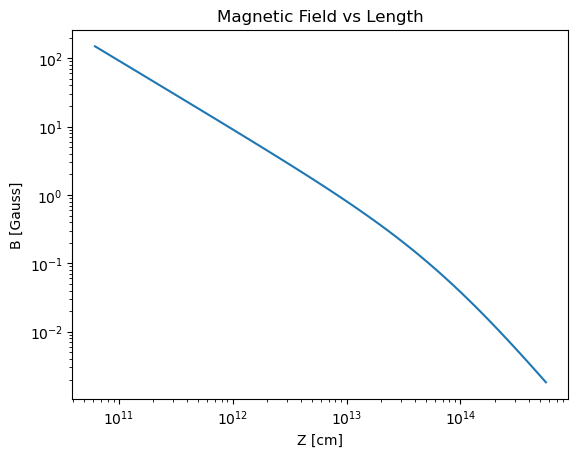

In [5]:
#Now we need to define the Source Function to find the Specific Intensity per
#slice.
#First, we need to define the Total Power of the jet.
#Since the Total Power of the Jet has two terms that depends on Radius,
#we define them first.

#First parameter that depends on Radius is the Magnetic Field.
def B(z, delta_z):
    """Takes the distance and calculates the Magnetic Field Strength 
    at that distance."""
    
    #We first find the initial Area.
    Area_initial_B = radius_initial * delta_z_initial
    
    #Then we find the current Area of the jet.
    Area_B = Radius(z) * delta_z
    
    #Now we can find the Magnetic Field for every distance thanks to the
    #Magnetic Flux being conserved throughout the jet.
    magnetic_field = (Magnetic_Field_initial * Area_initial_B) / (Area_B)
    
    #print(Magnetic_Field_initial * Area_initial_B)
    #print(magnetic_field * Area_B)
    return magnetic_field

B(z, delta_z)

plt.figure()
plt.plot(z, B(z, delta_z))
plt.title("Magnetic Field vs Length")
plt.xlabel("Z [cm]")
plt.ylabel(r"B [Gauss]")
plt.xscale("log")
plt.yscale("log")
plt.show()

In [6]:
#We define the function for frequency interval.
def Frequency(B):
    """Takes the distance and calculates the Frequency Interval, using the
    initial and final Magnetic Field Strength."""
    
    #We get the Magnetic Field Strength array.
    magnetic_field_array = B

    #We find the lower and upper frequency limits.
    lower_frequency = (3*(1**2)*q*magnetic_field_array[-1])/(2*mass_e*c)
    upper_frequency = (3*(gamma**2)*q*magnetic_field_array[0])/(2*mass_e*c)

    #We divide by 2pi since it is the Angular Frequency
    lower_frequency = lower_frequency/(2*np.pi)
    upper_frequency = upper_frequency/(2*np.pi)
    
    #We find the frequency interval that is in logspace.
    lower_frequency = format(lower_frequency, "e")
    upper_frequency = format(upper_frequency, "e")
    
    #We strip the exponential part of the frequencies.
    lower_frequency = (lower_frequency.split("e"))
    upper_frequency = (upper_frequency.split("e"))

    #Now we get the exponent part of the frequencies.
    lower_frequency = int(lower_frequency[1])
    upper_frequency = int(upper_frequency[1])

    #Now we use these to find the frequency interval.
    frequency = np.logspace(lower_frequency, upper_frequency, 100)
    #frequency = np.logspace(3, 14, 100)
    
    return frequency[0:-1]

Frequency(B(z, delta_z))

array([1.00000000e+03, 1.29154967e+03, 1.66810054e+03, 2.15443469e+03,
       2.78255940e+03, 3.59381366e+03, 4.64158883e+03, 5.99484250e+03,
       7.74263683e+03, 1.00000000e+04, 1.29154967e+04, 1.66810054e+04,
       2.15443469e+04, 2.78255940e+04, 3.59381366e+04, 4.64158883e+04,
       5.99484250e+04, 7.74263683e+04, 1.00000000e+05, 1.29154967e+05,
       1.66810054e+05, 2.15443469e+05, 2.78255940e+05, 3.59381366e+05,
       4.64158883e+05, 5.99484250e+05, 7.74263683e+05, 1.00000000e+06,
       1.29154967e+06, 1.66810054e+06, 2.15443469e+06, 2.78255940e+06,
       3.59381366e+06, 4.64158883e+06, 5.99484250e+06, 7.74263683e+06,
       1.00000000e+07, 1.29154967e+07, 1.66810054e+07, 2.15443469e+07,
       2.78255940e+07, 3.59381366e+07, 4.64158883e+07, 5.99484250e+07,
       7.74263683e+07, 1.00000000e+08, 1.29154967e+08, 1.66810054e+08,
       2.15443469e+08, 2.78255940e+08, 3.59381366e+08, 4.64158883e+08,
       5.99484250e+08, 7.74263683e+08, 1.00000000e+09, 1.29154967e+09,
      

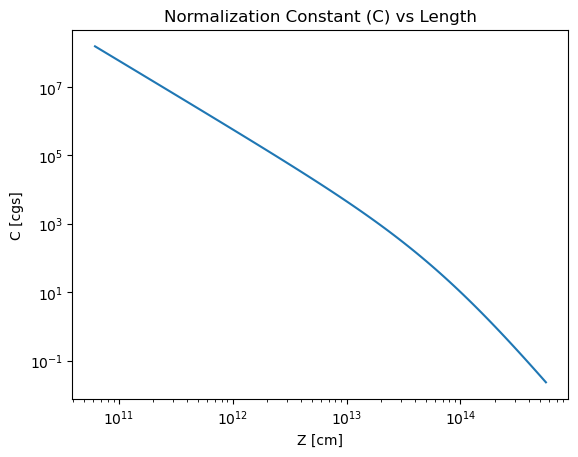

In [7]:
#Next, we define the Normalization Constant for the Power.
def C(B):
    """Takes the distance and calculates the Normalization Constant for Power
    so "C" at that time."""
    
    #Assuming Equipartition, since U_e = U_b we can write the following for the
    #first part of the normalization constant C hat.
    normalization_constant_1 = (B**2) / (8*np.pi)
    
    #We need to divide U_e with the logarithm of the Lorentz Factor we have.
    #For that we write the second part of the normalization constant.
    normalization_constant_2 = np.log(gamma)
    
    #From here, C hat can be written as follows.
    normalization_constant = normalization_constant_1 / normalization_constant_2
    
    #So far we got the C hat.
    #Since C is equal to C hat divided by the mass of electron and speed of 
    #light squared we can write the following.
    normalization_constant = normalization_constant / (mass_e * (c ** 2))
    
    return normalization_constant

C(B(z, delta_z))

plt.figure()
plt.plot(z, C(B(z, delta_z)))
plt.title(r"Normalization Constant (C) vs Length")
plt.xlabel("Z [cm]")
plt.ylabel(r"C [cgs]")
plt.xscale("log")
plt.yscale("log")
plt.show()

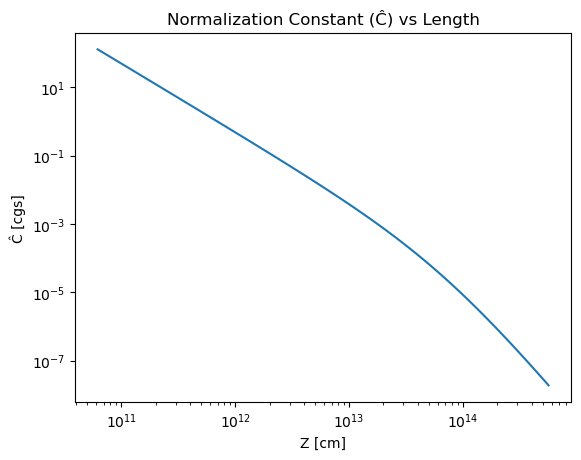

In [8]:
#Now we can also define the Normalization Constant for Absorption Coefficient.
def C_hat(B):
    """Takes the distance and calculates the Normalization Constant for 
    Absorption Coefficient so "C hat" at that time."""
    
    #Assuming Equipartition, since U_e = U_b we can write the following for the
    #first part of the normalization constant C hat.
    normalization_constant_1 = (B**2) / (8*np.pi)
    
    #We need to divide U_e with the logarithm of the Lorentz Factor we have.
    #For that we write the second part of the normalization constant.
    normalization_constant_2 = np.log(gamma)
    
    #From here, C hat can be written as follows.
    normalization_constant = normalization_constant_1 / normalization_constant_2
    
    return normalization_constant

C_hat(B(z, delta_z))

plt.figure()
plt.plot(z, C_hat(B(z, delta_z)))
plt.title(r"Normalization Constant (Ĉ) vs Length")
plt.xlabel("Z [cm]")
plt.ylabel(r"Ĉ [cgs]")
plt.xscale("log")
plt.yscale("log")
plt.show()

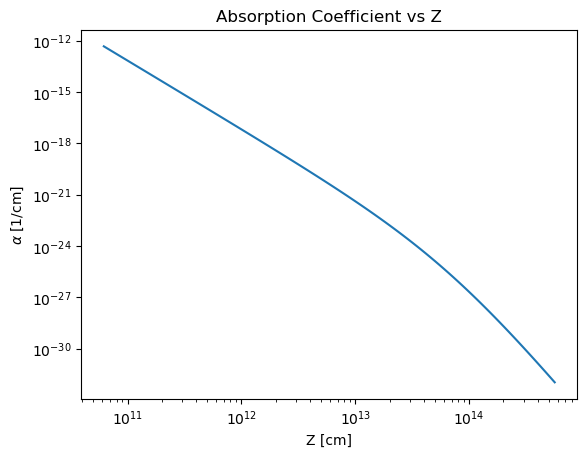

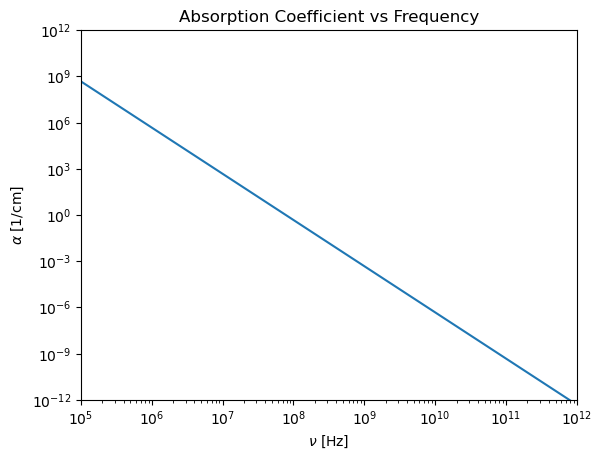

In [9]:
#Now we define the Absorption Coefficient. (Using the formula from the question)
def alpha_nu(B, C_hat, frequency):
    """Takes the distance and the frequency, then calculates the Absorption 
    Coefficient at that distance and frequency."""
    
    #We will split all the multiplications to avoid writing the whole equation
    #in one line.
    abs_coeff_1 = (np.sqrt(3)*pow(q,3))/(8*np.pi*mass_e)
    abs_coeff_2 = ((3*q)/(2*math.pi*pow(mass_e,3)*pow(c,5))) ** (p/2)
    abs_coeff_3 = C_hat
    abs_coeff_4 = B ** ((p+2)/2)
    abs_coeff_5 = math.gamma(((3*p+2)/12)) * math.gamma(((3*p+22)/12))
    abs_coeff_6 = frequency ** (-(p+4)/2)

    #Absorption Coefficient
    abs_coeff = abs_coeff_1 * abs_coeff_2 * abs_coeff_3 * abs_coeff_4 * abs_coeff_5 * abs_coeff_6

    return abs_coeff

alpha_nu(B(z, delta_z), C_hat(B(z, delta_z)), Frequency(B(z, delta_z)))

plt.figure()
plt.plot(z, alpha_nu(B(z, delta_z), C_hat(B(z, delta_z)), frequency_SSA))
plt.title("Absorption Coefficient vs Z")
plt.xlabel("Z [cm]")
plt.ylabel(r"$\alpha$ [1/cm]")
plt.xscale("log")
plt.yscale("log")
plt.show()

plt.figure()
plt.plot(Frequency(B(z, delta_z)), alpha_nu(B(z, delta_z)[0], C_hat(B(z, delta_z))[0], Frequency(B(z, delta_z))))
plt.title("Absorption Coefficient vs Frequency")
plt.xlabel(r"$\nu$ [Hz]")
plt.ylabel(r"$\alpha$ [1/cm]")
plt.xlim(1e5, 1e12)
plt.ylim(1e-12, 1e12)
plt.xscale("log")
plt.yscale("log")
plt.show()

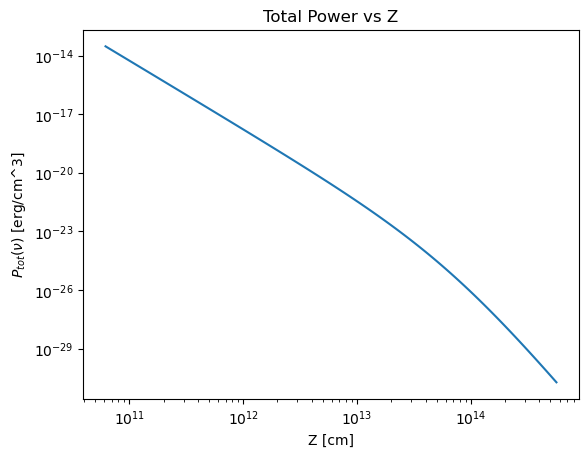

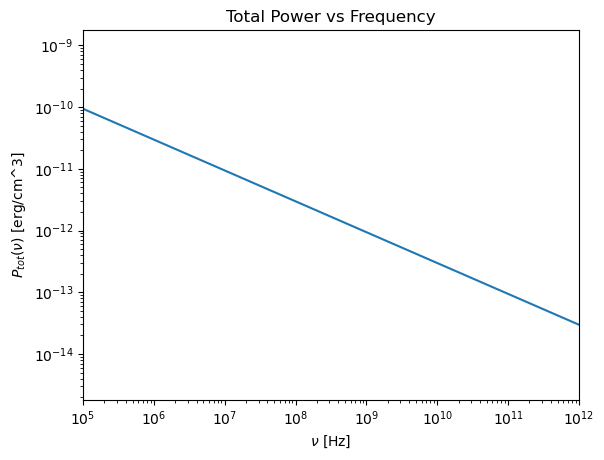

In [10]:
#Now we define the Total Power. (Using the Formula from the question)
def P_total(B, C, frequency):
    """Takes the distance and the frequency, then calculates the Total Power 
    at that distance and frequency."""
    
    #We will split all the multiplications to avoid writing the whole equation
    #in one line.
    total_power_1 = (1e-22)/(p+1)
    total_power_2 = C
    total_power_3 = B
    total_power_4 = ((1e-7 * frequency)/(B)) ** (-(p-1)/2)

    #Total Power
    total_power = total_power_1 * total_power_2 * total_power_3 * total_power_4
    
    return total_power

P_total(B(z, delta_z), C(B(z, delta_z)), Frequency(B(z, delta_z)))

plt.figure()
plt.plot(z, P_total(B(z, delta_z), C(B(z, delta_z)), frequency_SSA))
plt.title("Total Power vs Z")
plt.xlabel("Z [cm]")
plt.ylabel(r"$P_{tot}(\nu)$ [erg/cm^3]")
plt.xscale("log")
plt.yscale("log")
plt.show()

plt.figure()
plt.plot(Frequency(B(z, delta_z)), P_total(B(z, delta_z)[0], C(B(z, delta_z))[0], Frequency(B(z, delta_z))))
plt.title("Total Power vs Frequency")
plt.xlabel(r"$\nu$ [Hz]")
plt.ylabel(r"$P_{tot}(\nu)$ [erg/cm^3]")
plt.xlim(1e5, 1e12)
plt.xscale("log")
plt.yscale("log")
plt.show()

In [11]:
#Now we can get the Source Function.
def S_nu(P_total, alpha_nu):
    """Takes the distance and the frequency, then calculates the Source Function
    at that distance and frequency."""
    
    source_function = P_total / (4 * np.pi * alpha_nu)
    
    return source_function

S_nu(P_total(B(z, delta_z), C(B(z, delta_z)), Frequency(B(z, delta_z))), alpha_nu(B(z, delta_z), C_hat(B(z, delta_z)), Frequency(B(z, delta_z))))

array([1.57165937e-25, 3.12145250e-25, 6.19950246e-25, 1.23128594e-24,
       2.44547470e-24, 4.85701909e-24, 9.64670635e-24, 1.91598089e-23,
       3.80545363e-23, 7.55831776e-23, 1.50123141e-22, 2.98177105e-22,
       5.92250589e-22, 1.17636395e-21, 2.33659475e-21, 4.64120871e-21,
       9.21903358e-21, 1.83124702e-20, 3.63761219e-20, 7.22594353e-20,
       1.43543083e-19, 2.85154635e-19, 5.66487155e-19, 1.12541388e-18,
       2.23587873e-18, 4.44221241e-18, 8.82606134e-18, 1.75368944e-17,
       3.48464297e-17, 6.92445559e-17, 1.37605817e-16, 2.73472724e-16,
       5.43525310e-16, 1.08033077e-15, 2.14747377e-15, 4.26910007e-15,
       8.48761407e-15, 1.68763888e-14, 3.35600151e-14, 6.67448824e-14,
       1.32761409e-13, 2.64112562e-13, 5.25503104e-13, 1.04577127e-12,
       2.08151709e-12, 4.14392891e-12, 8.25166122e-12, 1.64352220e-11,
       3.27433999e-11, 6.52522555e-11, 1.30077156e-10, 2.59388757e-10,
       5.17436898e-10, 1.03259967e-09, 2.06152109e-09, 4.11754484e-09,
      

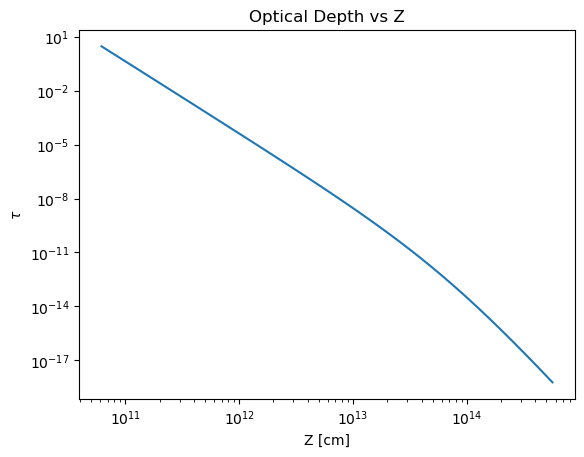

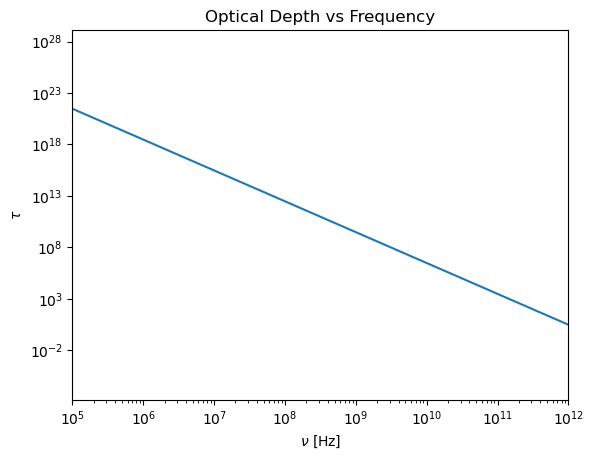

In [12]:
#Now we also can get the Optical Depth.
def tau(alpha_nu, Radius):
    """Takes the distance and frequency, then calculates the Optical Depth at 
    that distance and frequency."""
    
    optical_depth = alpha_nu * Radius
    
    return optical_depth

tau(alpha_nu(B(z, delta_z), C_hat(B(z, delta_z)), Frequency(B(z, delta_z))), Radius(z))

plt.figure()
plt.plot(z, tau(alpha_nu(B(z, delta_z), C_hat(B(z, delta_z)), frequency_SSA), Radius(z)))
plt.title("Optical Depth vs Z")
plt.xlabel("Z [cm]")
plt.ylabel(r"$\tau$")
plt.xscale("log")
plt.yscale("log")
plt.show()

plt.figure()
plt.plot(Frequency(B(z, delta_z)), tau(alpha_nu(B(z, delta_z)[0], C_hat(B(z, delta_z)[0]), Frequency(B(z, delta_z))), Radius(z)[0]))
plt.title("Optical Depth vs Frequency")
plt.xlabel(r"$\nu$ [Hz]")
plt.ylabel(r"$\tau$")
plt.xlim(1e5, 1e12)
plt.xscale("log")
plt.yscale("log")
plt.show()

In [13]:
#We can now define the Intensity at given distance!
def I_nu(S_nu, tau):
    """Takes the distance and frequency, then calculates the Specific Intensity 
    at that distance and frequency."""

    specific_intensity = S_nu * (1 - np.exp(-tau))

    return specific_intensity

I_nu(S_nu(P_total(B(z, delta_z), C(B(z, delta_z)), Frequency(B(z, delta_z))), alpha_nu(B(z, delta_z), C_hat(B(z, delta_z)), Frequency(B(z, delta_z)))), tau(alpha_nu(B(z, delta_z), C_hat(B(z, delta_z)), Frequency(B(z, delta_z))), Radius(z)))

array([1.57165937e-25, 3.12145250e-25, 6.19950246e-25, 1.23128594e-24,
       2.44547470e-24, 4.85701909e-24, 9.64670635e-24, 1.91598089e-23,
       3.80545363e-23, 7.55831776e-23, 1.50123141e-22, 2.98177105e-22,
       5.92250589e-22, 1.17636395e-21, 2.33659475e-21, 4.64120871e-21,
       9.21903358e-21, 1.83124702e-20, 3.63761219e-20, 7.22594353e-20,
       1.43543083e-19, 2.85154635e-19, 5.66487155e-19, 1.12541388e-18,
       2.23587873e-18, 4.44221241e-18, 8.82606134e-18, 1.75368944e-17,
       3.48464297e-17, 6.92445559e-17, 1.37605817e-16, 2.73472724e-16,
       5.43525310e-16, 1.08033077e-15, 2.14747377e-15, 4.26910007e-15,
       8.48761407e-15, 1.68763888e-14, 3.35600151e-14, 6.67448824e-14,
       1.32761409e-13, 2.64112562e-13, 5.25503104e-13, 1.04577127e-12,
       2.08151709e-12, 4.14392891e-12, 8.25166122e-12, 1.64352220e-11,
       3.27433999e-11, 6.52522555e-11, 1.30077156e-10, 2.59388757e-10,
       5.17436898e-10, 1.03259486e-09, 2.01570222e-09, 2.84842590e-09,
      

In [14]:
#From here, we finally define our Flux which depends on Intensity, Area of
#the emitting surface and our distance to the slice.

def Flux(I_nu, Radius, delta_z, D, frequency):
    """Takes the distance array then calculates the Flux at that frequency
    interval."""
    
    #We define an array for flux values for the distance we are in.
    flux_distance = np.zeros(len(frequency))
    
    #Now we find the flux for each frequency in order to create an array of our
    #frequency and flux values, which will give us the spectrum for that 
    #distance.
    
    #We also do the conversion from erg/cm^2 to mJy here.
    #(1 Jy = 1e-23 erg/cm^2 => 1 mJy = 1e-20 erg/cm^2)
    flux_1 = (4 * np.pi) * ((I_nu)/1e-26)
    flux_2 = (2 * np.pi * Radius * delta_z)
    flux_3 = (4 * np.pi * (D**2))
    
    #We add the fluxes to our flux_distance array, which will be an array 
    #that gives us the spectrum for that distance.
    flux_distance = (flux_1 * flux_2)/(flux_3)
    
    return flux_distance

flux = Flux(I_nu(S_nu(P_total(B(z, delta_z), C(B(z, delta_z)), Frequency(B(z, delta_z))), alpha_nu(B(z, delta_z), C_hat(B(z, delta_z)), Frequency(B(z, delta_z)))), tau(alpha_nu(B(z, delta_z), C_hat(B(z, delta_z)), Frequency(B(z, delta_z))), Radius(z))), Radius(z), delta_z, D, Frequency(B(z, delta_z)))

# Monte - Carlo and SSC (Synchrotron Self Compton) <a id="Monte - Carlo & SSC (Synchrotron Self Compton)"></a>

In [61]:
#We import the libraries we will need.
#We import our classic libraries.
import numpy as np
import matplotlib.pyplot as plt
import scipy

#For integration we will do
import scipy.integrate as integrate
from scipy.integrate import quad

#We also create a figure_counter
figure_counter = 0

In [62]:
#We first have to define our Monte-Carlo Parameter Set.
#For this we create two "dummy" functions for our Photon and Electron Velocity
#Distributions as follows.

#We will define this later.
def f_of_v_mono():
    return(0)

#We will define this later.
def f_of_hnu_mono():
    return(0)

#Now we define our Monte-Carlo Parameter Set!
    #n_photons: Number of Trials/Photons
    #kt_seeds: Temperature/Energy of the Seed Photons (in Energy Units)
    #H: Height of the Corona (H ~ R ~ 100 R_g ~ 3e7 cm)
    #velocity: Electron Velocity (Only used by Mono-Energetic Distribution)
    #kt_electron: Electron Temperature (in Energy Units, used by Maxwellian)
    #tau: Optical Depth of the Corona
    #v_dist: Soon to be Power Law!
    #hnu_dist: Soon to be Planck Distribution!

mc_params={'n_photons':10000,
          'kt_seeds':1.6e-9,
          'H':1e7,
          'velocity':3e9,
          'tau':0.1,
          'kt_electron':3.2e-8,
          'v_dist':f_of_v_mono,
          'hnu_dist':f_of_hnu_mono}

In [63]:
#We also need to setup our Frequency Function so that it returns number of 
#frequencies equal to the number of photons we will consider.
#Same goes for our distance interval as well!
distance = np.logspace(-1, 3, mc_params["n_photons"])
#distance = np.logspace(-1, 3, 100)

distance_diff = np.diff(distance)

def Frequency(distance):
    """Takes the distance and calculates the Frequency Interval, using the
    initial and final Magnetic Field Strength."""
    
    #We get the Magnetic Field Strength array.
    magnetic_field_array = Magnetic_Field(distance, distance_diff)

    #We find the lower and upper frequency limits.
    lower_frequency = (3*(1**2)*q*magnetic_field_array[-1])/(2*mass_e*c)
    upper_frequency = (3*(gamma**2)*q*magnetic_field_array[0])/(2*mass_e*c)
    
    #We divide by 2pi since it is the Angular Frequency
    lower_frequency = lower_frequency/(2*np.pi)
    upper_frequency = upper_frequency/(2*np.pi)
    
    #We find the frequency interval that is in logspace.
    lower_frequency = format(lower_frequency, "e")
    upper_frequency = format(upper_frequency, "e")
    
    #We strip the exponential part of the frequencies.
    lower_frequency = (lower_frequency.split("e"))
    upper_frequency = (upper_frequency.split("e"))

    #Now we get the exponent part of the frequencies.
    lower_frequency = int(lower_frequency[1])
    upper_frequency = int(upper_frequency[1])

    #Now we use these to find the frequency interval.
    #frequency = np.logspace(lower_frequency, upper_frequency, 100)
    frequency = np.logspace(lower_frequency, upper_frequency, mc_params["n_photons"])
    #frequency = np.logspace(3, 17, 100)
    
    return frequency[0:-1]

#We remove the last slice.
distance = distance[0:-1]

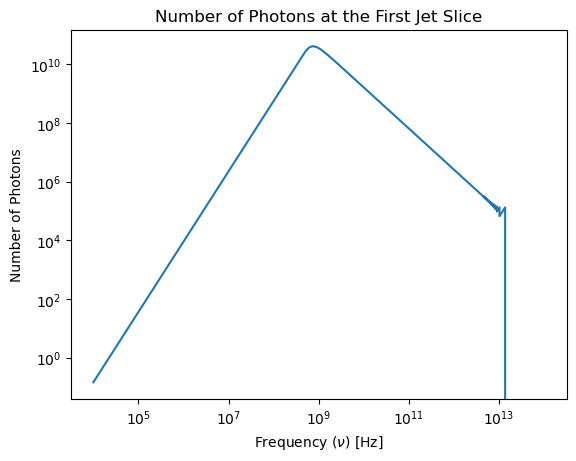

In [64]:
#We first need to have a Photon Field.
#Which means we have to use the Specific Intensity of our first slice.

#Note that we need to divide it by Planck Constant and Frequency to get the
#Intensity in terms of kT! (The Functions we use uses Intensity in terms of kT)
number_of_photons = (Specific_Intensity(radius_initial, Frequency(distance)))/(planck_constant * Frequency(distance))

#Now we plot our results.
plt.figure()

plt.plot(Frequency(distance), number_of_photons)

plt.title("Number of Photons at the First Jet Slice")
plt.xlabel(r"Frequency ($\nu$) [Hz]")
plt.ylabel(r"Number of Photons")

plt.xscale("log")
plt.yscale("log")

plt.show()

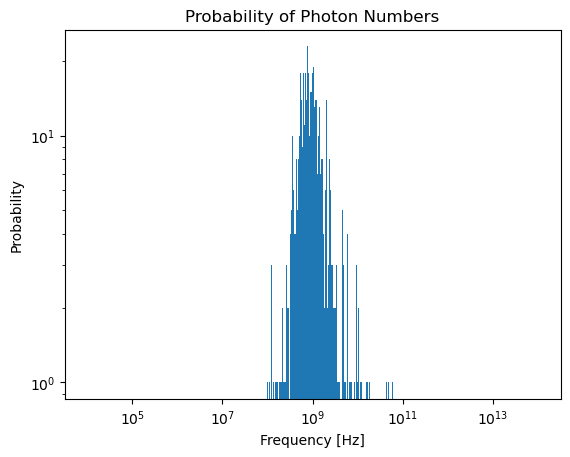

In [65]:
#We get the PDF of Number of Photons.
pdf = number_of_photons/np.sum(number_of_photons)

#We use np.cumsum to find the Cumulative Probability Distribution Function.
cdf = np.cumsum(pdf)

#Now we define different probabilities using np.random.rand()
prob = np.random.rand(mc_params["n_photons"])

#Now we interpolate our probabilities with cdf and frequency as follows.
interpolation = np.interp(prob, cdf, Frequency(distance))

#Now we plot our results as follows.
plt.figure()
#plt.plot(Frequency(distance), number_of_photons, "--")
plt.hist(interpolation, bins = Frequency(distance))
plt.title("Probability of Photon Numbers")
plt.xlabel(r"Frequency [Hz]")
plt.ylabel(r"Probability")
plt.xscale("log")
plt.yscale("log")
plt.show()

#The resulting plot is in correlation with our Number of Photons at the first
#slice! (Remove the "#" above to see)

In [66]:
#Now we define the Planck Distribution as follows.
#------------------------------------------------------------------------------
def f_planck(x):
    """Photon Distribution Function of a Planck Distribution.
    
    --------------------------------------------------------------------
    Args:
        x (Real): Photon Energy E in units of kT
    --------------------------------------------------------------------
    Returns:
        Real: Differential Photon Number dN/dE at the Energy E """
    
    #We define the normalization constant.
    norm = 2.4041138063192817
    
    #Now we find the differential photon number at the Energy "x"
    photon_number = x**2/((np.exp(x)-1) * norm)
    
    #We return the differential photon number at that energy.
    return photon_number

#------------------------------------------------------------------------------
#We define another Planck Distribution for the Numerical Integration of the
#cumulative Planck Probability Distribution Function. (Which will be inverted)

def p_planck(hnu = None):
    """Numerical Integration of Cumulative Planck PDF (to be inverted).
    
    --------------------------------------------------------------------
    Args:
        hnu (Numpy Array): Bins of Photon Energy E in units of kT
    --------------------------------------------------------------------
    Returns:
        Numpy Array: Cumulative Photon Probability Distribution Function
    as a Function of hnu
    
        Numpy Array: hnu values used for Probability Distribution Function"""
    
    #If no Bins of Photon Energy is provided, we'll do the following to define
    #our own Bins of Photon Energy as follows.
    if (hnu is None):
        number = 1000
        hnu = np.append(np.linspace(0, 1-1./number, number), np.logspace(0, 4, number))
    
    #If the Bins of Photon Energy is provided, we do the following.
    p = np.zeros(2 * number)
    
    for i in range(1, 2 * number):
        p[i] = ((quad(f_planck, 0, hnu[i]))[0])
    
    #We return the Cumulative Photon PDF and hnu values for PDF.
    return p, hnu

#------------------------------------------------------------------------------
#Now we have to invert the Planck Probability Density Function which we can
#do with the following function.

def hnu_of_p_planck(number = None, pdf = None, hnu = None):
    """Numerically Inverts the Planck Probability Density Function.
    
    --------------------------------------------------------------------
    Args:
        None
        
    Parameters:
        planck_pdf (Numpy Array): Previously Calculated Planck PDF
        planck_hnu (Numpy Array): Energy Grid for PDF
        number (Integer): Number of Photon Energies to Generate
    --------------------------------------------------------------------
    Returns:
        Numpy Array: Energies corresponding to p
        Numpy Array: Cumulative PDF used to calculate the E
        Numpy Array: hnu grid used to calculate the PDF """
    
    #If no Bins of Photon Energy is provided, we'll do the following to define
    #our own Bins of Photon Energy as follows.
    if number is None:
        number = 1
        
    #If no PDF is provided, we'll do the following to define our PDF.
    if pdf is None:
        pdf, hnu = p_planck()
    
    #We now find the Energies of our Photons as follows.
    e_photon = np.interp(np.random.rand(number), pdf, hnu)
    
    #We return the Energies, Cumulative PDF and the hnu grid.
    return e_photon, pdf, hnu

#------------------------------------------------------------------------------
#We define the Planck Distribution for Photons.
#We can change the Photon distribution easily by mc_params['hnu_dist'] = f_of_hnu_planck

def f_of_hnu_planck(mc_params, number = None, pdf = None, energies = None):
    """Returns Randomly Drawn Photon Energy from the Planck Distribution.
    
    --------------------------------------------------------------------
    Args:
        mc_params (Dictionary): Monte - Carlo Parameters
    
    Parameters:
        pdf (Numpy Array): Previously Calculated Planck PDF
        hnu (Numpy Array): Energy Grid for PDF
    --------------------------------------------------------------------
    Returns:
        Numpy Array: Seed Photon Energies drawn from Photon Distribution. """
    
    #If there are no numbers given, we'll take it as one.
    if number is None:
        number = 1
    
    #If there is no PDF given, we'll get it from our 
    #hnu_of_p_planck(number = number) function!
    if pdf is None:
        e, pdf, energies = hnu_of_p_planck(number = number)
    
    #If there is a pdf, we do the following.
    else:
        e, pdf, energies = hnu_of_p_planck(number = number, pdf = pdf, hnu = energies)
    
    #We now calculate the energies for photons.
    e *= mc_params["kt_seeds"]
    
    return(e)
#------------------------------------------------------------------------------


C:\Users\kayah\AppData\Local\Temp\ipykernel_14852\1974546049.py:17: RuntimeWarning: overflow encountered in exp
  photon_number = x**2/((np.exp(x)-1) * norm)
C:\Users\kayah\AppData\Local\Temp\ipykernel_14852\1974546049.py:17: RuntimeWarning: overflow encountered in scalar multiply
  photon_number = x**2/((np.exp(x)-1) * norm)


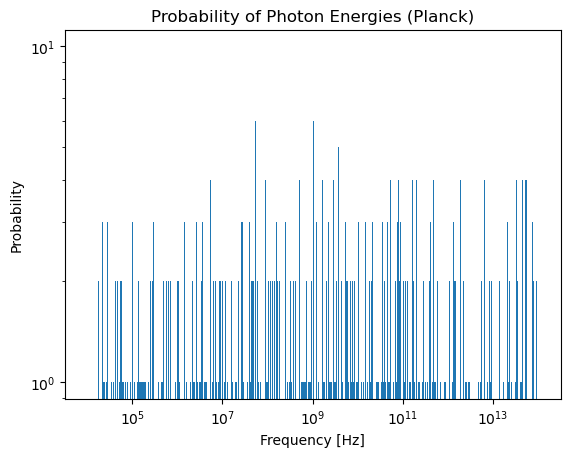

In [67]:
e = f_of_hnu_planck(mc_params, number = mc_params["n_photons"], pdf = None, energies = None)
e = e[0:-1]
#We get the PDF of Number of Electrons.
#Note that Power_Law(gamma_values) give us the Electron Number N(E)!
pdf = e/np.sum(e)

#We use np.cumsum to find the Cumulative Probability Distribution Function.
cdf = np.cumsum(pdf)

#Now we define different probabilities using np.random.rand()
prob = np.random.rand(mc_params["n_photons"])

#Now we interpolate our probabilities with cdf and frequency as follows.
interpolation = np.interp(prob, cdf, Frequency(distance))

#Now we plot our results as follows.
plt.figure()
#plt.plot(Frequency(distance), number_of_photons, "--")
plt.hist(interpolation, bins = Frequency(distance))
plt.title("Probability of Photon Energies (Planck)")
plt.xlabel(r"Frequency [Hz]")
plt.ylabel(r"Probability")
plt.xscale("log")
plt.yscale("log")
plt.show()

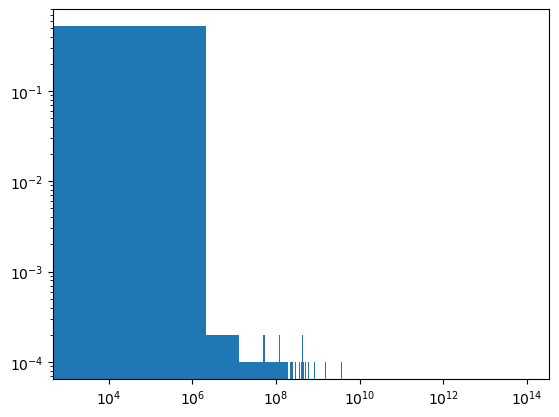

In [68]:
histogram, bin_edges = np.histogram(number_of_photons, bins = 10000, density = True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

pdf = histogram/np.sum(histogram)

plt.figure()
plt.bar(Frequency(distance), pdf[0:-1], width = (bin_edges[1] - bin_edges[0]))
plt.xscale("log")
plt.yscale("log")
plt.show()

C:\Users\kayah\AppData\Local\Temp\ipykernel_14852\1974546049.py:17: RuntimeWarning: overflow encountered in exp
  photon_number = x**2/((np.exp(x)-1) * norm)
C:\Users\kayah\AppData\Local\Temp\ipykernel_14852\1974546049.py:17: RuntimeWarning: overflow encountered in scalar multiply
  photon_number = x**2/((np.exp(x)-1) * norm)


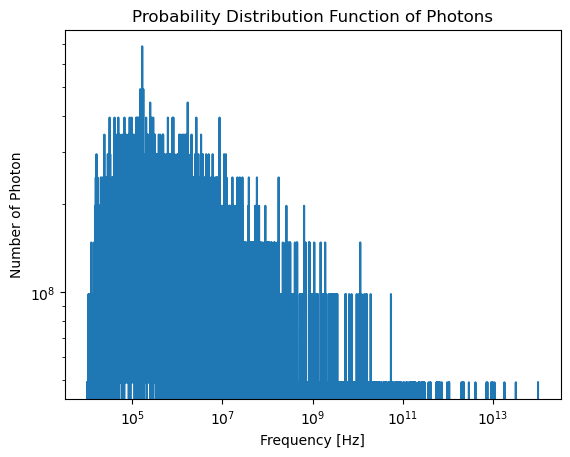

In [69]:
#We plot the Planck Function to see how it looks.
plt.figure()

#We create the histogram.
histogram, bins = np.histogram(f_of_hnu_planck(mc_params, mc_params["n_photons"]), bins = mc_params["n_photons"]-1, density = True)

plt.plot(Frequency(distance), histogram)
plt.title("Probability Distribution Function of Photons")
plt.xlabel(r"Frequency [Hz]")
plt.ylabel(r"Number of Photon")
plt.xscale("log")
plt.yscale("log")

plt.show()

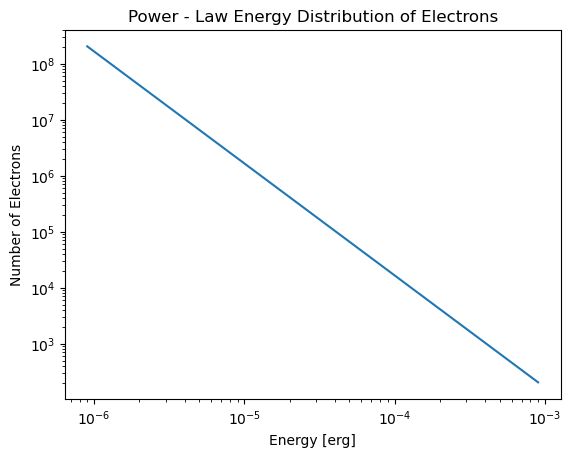

In [70]:
#We also define the Power Law for the Electron Distribution.
#For this we first have to define the change in gamma values.
gamma_values = np.logspace(0, 3, mc_params["n_photons"])
gamma_values = gamma_values[0:-1]

#We also define the Electron Distribution as follows.
def Power_Law(gamma_values):
    #We get the electron number per energy as follows.
    number_e = Norm_Constant_Abs_Coeff(radius_initial) * ((gamma_values * mass_e * (c**2)))**-p
    
    return number_e    

#Power - Law for Energies
plt.figure()
plt.loglog(((gamma_values * mass_e * (c**2))), Power_Law(gamma_values))
plt.title("Power - Law Energy Distribution of Electrons")
plt.xlabel(r"Energy [erg]")
plt.ylabel(r"Number of Electrons")
plt.show()

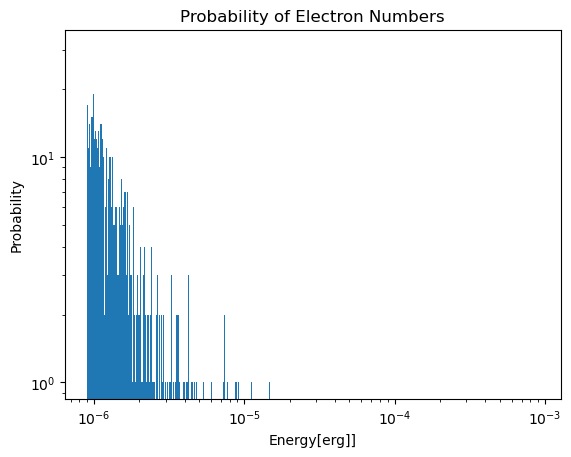

In [71]:
#We have to do the same thing we did for photons for electrons as well!

#We get the PDF of Number of Electrons.
#Note that Power_Law(gamma_values) give us the Electron Number N(E)!
pdf = Power_Law(gamma_values)/np.sum(Power_Law(gamma_values))

#We use np.cumsum to find the Cumulative Probability Distribution Function.
cdf = np.cumsum(pdf)

#Now we define different probabilities using np.random.rand()
prob = np.random.rand(mc_params["n_photons"])

#We find the Electron Energies since we are gonna use Energies on x-axis.
electron_energies = (Power_Law(gamma_values)/Norm_Constant_Abs_Coeff(radius_initial))**-(1/p)

#Now we interpolate our probabilities with cdf and frequency as follows.
interpolation = np.interp(prob, cdf, electron_energies)

#Now we plot our results as follows.
plt.figure()
#plt.plot(((gamma_values * mass_e * (c**2))), Power_Law(gamma_values), "--")
plt.hist(interpolation, bins = electron_energies)
plt.title("Probability of Electron Numbers")
plt.xlabel(r"Energy[erg]]")
plt.ylabel(r"Probability")
plt.xscale("log")
plt.yscale("log")
plt.show()

#The resulting plot is in correlation with our Number of Electrons in the Power
#Law. (Remove the "#" above to see)

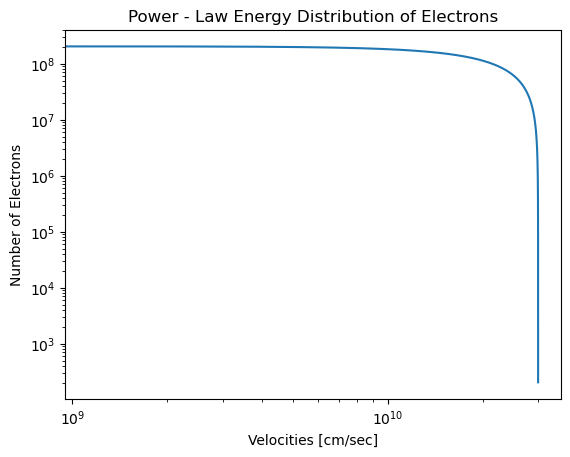

In [76]:
#Now we can define the Electron velocity distribution as follows:
def Power_Law_velocity(mc_params):
    #We get the electron number per energy as follows.
    gamma_value_1 = mc_params["number_electron"](mc_params["gamma_dist"])
    gamma_value_2 = Norm_Constant_Abs_Coeff(radius_initial) * (mass_e * (c**2))**(-p)
    gamma_value = gamma_value_1 / gamma_value_2
    
    gamma_value = gamma_value ** -(1/p)
    velocity = np.sqrt(((gamma_value**2)-1)/(gamma_value**2)) * c
    
    return velocity

velocity_electrons = Power_Law_velocity(mc_params)

#Now we show the Velocity Distribution of Electrons as follows.
plt.figure()
plt.loglog(velocity_electrons, Power_Law(gamma_values))
plt.title("Power - Law Energy Distribution of Electrons")
plt.xlabel(r"Velocities [cm/sec]")
plt.ylabel(r"Number of Electrons")
plt.show()

In [78]:
#We define a proper Maxwellian Velocity Distribution.

def f_of_v_maxwell(mc_params):
    """Returns a single randomly drawn velocity from the Distribution
    Function known as Maxwellian.
    
    --------------------------------------------------------------------
    Args:
        mc_params (Dictionary): Monte - Carlo Parameters
    --------------------------------------------------------------------
    Returns:
        Real: Electron Energy Drawn from Distribution """
    
    #We need to draw x, y, and z Velocities from a Maxwell-Boltzmann
    #Distribution and calculate the resulting speed.
    
    #This is a non-relativistic Maxwellian, so we must truncate it below
    #speed of light (c).
    
    #For this we define a random velocity value.
    velocity = 3e10
    
    #Now we check if this velocity is higher than speed of light.
    while velocity >= c:
        velocity = np.sqrt(mc_params["kt_electron"]/(mass_e)) * np.sqrt(np.sum((np.random.normal(0, 1, 3))**2))
    
    #We return the velocity.
    return velocity

f_of_v_maxwell(mc_params)

8899509494.617315

In [75]:
#Now we add both of our distributions to our Monte Carlo Parameters.
#We also will change a few of our Parameters in the dictionary, which will be
#shown on the code.

mc_params={'n_photons':10000, #We will work with 10000 photons.
          'kt_seeds':1.6e-9, #1 keV input photons
          'H':10*rg, # say H ~ R, and R ~ 100 R_g
          'velocity':c*0.3, #Velocity is 0.3 times the speed of light
          'tau':0.1, #tau ~ 0.1: Small-ish optical depth
          'kt_electron':3.2e-8, #20 keV
          'v_dist':f_of_v_maxwell, #Electron Velocity Distribution (Power Law)
          'hnu_dist':f_of_hnu_planck, #Photon Distribution (Planck)
          'gamma_dist':gamma_values, #Gamma Values
          'number_electron':Power_Law #Electron Number
         }

In [77]:
#Now we are getting into the Inverse Compton Scattering Part.
#For this we have to define the following functions.
def Compton_y(Before, After):
    return (np.mean((After - Before)/(Before)))

def Random_Direction(number = None):
    """Returns randomly oriented Unit Vectors.
    
    --------------------------------------------------------------------
    Args:
        None
        
    Parameters:
        number: Number of Random Vectors to Return
    --------------------------------------------------------------------
    Returns:
        (number, 3)-Element Numpy Array: Randomly Oriented Unit Vectors"""
    
    #If there are no numbers given, it will return 1 Direction Matrix.
    if number is None:
        number = 1
    
    #Now we calculate the orientations.
    #For this we will use np.random.rand() function to get a randomized
    #number!
    
    #First we calculate the Phi Orientation. (Phi is in Radians)
    #Note that np.random.rand() draws a single Randomized Number!
    phi = 2 * np.pi * np.random.rand(number)
    cos_phi = np.cos(phi)
    sin_phi = np.sin(phi)
    
    #We now calculate the Theta Orientation
    #Theta: Angle Measured from the z-axis!
    cos_theta = 2 * np.random.rand(number) - 1
    sin_theta = np.sqrt(1 - (cos_theta**2))
    
    #We get a Matrix of the Random Directions we have found.
    direction_matrix = np.array([sin_theta * cos_phi, sin_theta * sin_phi, cos_theta])
    
    #Now we turn this matrix into a [x, y, z] form!
    direction_matrix = direction_matrix.transpose()
    
    return direction_matrix

def Photon_Origin(number = None):
    """Returns the Emission Location of a Photon."""
    
    #If there are no numbers given, it will return 1 Photon Origin.
    if number is None:
        number = 1
    
    #We get the Emmited Photon's Location/Origin.
    photon_origin = np.zeros([number, 3])
    
    return photon_origin

def Draw_Seed_Photons(mc_params, number = None):
    """Returns a Single Seed Photon.
    
    --------------------------------------------------------------------
    Args:
        mc_params (Dictionary): Monte-Carlo Parameters
        
    Parameters:
        number (Integer): Number of Photons to Return
    --------------------------------------------------------------------
    Returns:
        (number x 4) Numpy Array: Photon Momentum 4-Vectors
        (number x 3) Numpy Array: Initial Photon Positions """
    
    #If there are no numbers given, it will return 1 Seed Photon.
    if number is None:
        number = 1
    
    #We define the Location/Origin of the Seed Photon.
    x_seed = Photon_Origin(number = number)
    
    #We define the Direction of the Seed Photon.
    n_seed = Random_Direction(number = number)
    
    #Now we find the Energy of the Seed Photon. (We use f_of_hnu_mono())
    hnu = mc_params["hnu_dist"](mc_params, number = number)
    
    #Finally, we get our Seed Photon.
    #Array will be in the shape of [Photon Energy, x direction, y direction, z direction]
    p_seed = (np.array([hnu, hnu * n_seed[: , 0], hnu * n_seed[: , 1], hnu * np.abs(n_seed[: , 2])]))
    
    #We take the transpose of this.
    p_seed = p_seed.transpose()
    
    #Now we divide this with speed of light.
    p_seed = p_seed / c
    
    #We will get the (Energy + Location) & Origin of the photon as follows.
    return(p_seed, x_seed)

def Tau_of_Scatter():
    """Calculates Optical Depth a Photon Travelled to before interacting,
    given the Probability.
    
    --------------------------------------------------------------------
    Args:
        None
    --------------------------------------------------------------------
    Returns:
        Real: Optical Depth as a function of P (Probability)"""
    
    #We draw our Random Probability "P"!
    tau = - np.log(np.random.rand())
    
    return tau

def Distance_of_Scatter(mc_params):
    """Calculates the distance that corresponds to an Optical Depth Tau.
    
    --------------------------------------------------------------------
    Args:
        tau (Real): Optical Depth Photon travels before Scattering occurs.
        mc_params (Dictionary): Monte - Carlo Parameters
    --------------------------------------------------------------------
    Returns:
        Real: Distance """
    
    #First we get our Tau from our defined function.
    tau = Tau_of_Scatter()
    
    #Then we use this to find the electron density as follows:
    electron_density = mc_params["tau"]/(mc_params['H']*th_cross_sec)
    
    #From here, we can find the Pathlength as follows:
    pathlength = tau / (th_cross_sec * electron_density)
    
    return pathlength

#We define a function for Scattering Position.
def Scatter_Location(x_old, p_photon, mc_params):
    """Calculates the distance that corresponds to an Optical Depth Tau.
    
    --------------------------------------------------------------------
    Args:
        x_old (3-element Numpy Array): Holds the Position of the Photon
        p_photon (4-element Numpy Array): The Incoming Photon Four-Momentum
        mc_params (Dictionary): Monte - Carlo Parameters
    --------------------------------------------------------------------
    Returns:
        x_new (3-element Numpy Array): Scattering Location """
    
    #First we get our Pathlength of the photon.
    pathlength = Distance_of_Scatter(mc_params)
    
    #Then we find the Photon Direction.
    photon_direction = p_photon[1 : ]/p_photon[0]
    
    #Now we update the Photon Position with the New Location!
    x_new = x_old + (pathlength * photon_direction)
    
    return x_new

def mu_of_p_electron(beta, p):
    """Invert Probability for Foreshortened Effective Thomson Scattering
    Cross Section with the Probability P!
    
    --------------------------------------------------------------------
    Args:
        beta(Real): v/c for electron.
        p: Probability Value between 0 and 1.
    --------------------------------------------------------------------
    Returns:
        Real: mu (cos(theta)) Relative to the Photon Direction """
    
    #We calculate the Mu parameter. (which is cos(theta))
    mu = 1/beta - np.sqrt(1/beta**2 + 1 - 4*p/beta + 2/beta)
    
    return(mu)

def Draw_Electron_Velocity(mc_params, p_photon):
    """Returns a Randomized Electron Velocity Vector for Inverse Compton
    Scattering, taking Relativistic Foreshortening of the Photon Flux in
    the Electron Frame into account.
    
    --------------------------------------------------------------------
    Args:
        mc_params (Dictionary): Monte - Carlo Parameters
        p_photon (4-element Numpy Array): Photon Four-Momentum
    --------------------------------------------------------------------
    Returns:
        3-element Numpy Array: Electron Velocity """
    
    #We get the Electron Velocity from the mc_params v_dist, which is
    #f_of_v_mono.
    v = mc_params["v_dist"](mc_params)
    
    #We now get the Electron Direction using the formula we will define.
    n = Draw_Electron_Direction(v, p_photon)
    
    #We now multiply the Direction and Velocity to get the true velocity 
    #vector!
    velocity_vector = v * n
    
    return velocity_vector

def Draw_Electron_Direction(v, p_photon):
    """Draws a Randomized Electron Direction, taking account of the 
    increase in Photons Flux from the Forward Direction, which effectively
    increases the Cross Section for Forward Scattering.
    
    --------------------------------------------------------------------
    Args:
        v (Real): Electron Velocity
        p_photon (4-element Numpy Array): Photon Four-Momentum
    --------------------------------------------------------------------
    Returns:
        3-element Numpy Array: Randomized Electron Velocity Vector """
    
    #First we calculate the Phi Orientation. (Phi is in Radians)
    #Note that np.random.rand() draws a single Randomized Number!
    phi = 2 * np.pi * np.random.rand()
    cos_phi = np.cos(phi)
    sin_phi = np.sin(phi)
    
    #We now calculate the Theta Orientation
    #Theta: Angle Measured from the z-axis!
    #We get these from a function we will define next!
    cos_theta = mu_of_p_electron(v/c, np.random.rand())
    sin_theta = np.sqrt(1 - (cos_theta**2))
    
    #Now we calculate the Unit Vectors.
    n_1 = p_photon[1: ] / p_photon[0]
    
    if (np.sum(np.abs(n_1[1:2])) != 0):
        n_2 = np.cross(n_1, np.array([1,0,0]))
    else:
        n_2 = np.cross(n_1, np.array([0,1,0]))
    
    n_2 /= np.sqrt(np.sum(n_2**2))
    n_3 = np.cross(n_1, n_2)
    
    #We express the new Vector in the old base.
    n_new = (((n_2 * cos_phi) + (n_3 * sin_phi)) * sin_theta) + (n_1 * cos_theta)
    
    #We arrange the new Vector.
    n_new = n_new / (np.sqrt(np.sum(n_new ** 2)))
    
    return n_new

def Lorentz_Transform(p, v):
    """Returns the General Lorentz Transform.
    
    --------------------------------------------------------------------
    Args:
        p (4-Element Numpy Array): Input of 4-Vector.
        v (3-Element Numpy Array): The 3-Velocity of the Frame we want
    to transform into.
    --------------------------------------------------------------------
    Returns:
        4-Element Numpy Array: The Transformed 4-Vector """
    
    #We first find the Beta velocity.
    beta = np.sqrt(np.sum(v**2))/c
    
    #Then we find the Beta velocity's Vector.
    beta_vector = v/c
    
    #Then we find the Lorentz/Gamma Factor
    gamma = 1/np.sqrt(1 - beta**2)
    
    #Then we create a matrix of 4x4 zeros.
    matrix = np.zeros((4,4))
    
    #We fill in this matrix with the Lorentz Transform elements.
    #We are basically creating the transform matrix.
    matrix[0, 0] = gamma
    matrix[1: , 0]= -gamma * beta_vector
    matrix[0, 1: ]= -gamma * beta_vector
    matrix[1: , 1: ]= (gamma-1) * np.outer(beta_vector,beta_vector) / beta**2
    
    #Since some elements need the "+1" in our transform matrix we add that too.
    for i in range(1,4):
        matrix[i, i]+=1
    
    #We do our Lorentz Transform.
    transformed = np.dot(matrix, p)
    
    return transformed

def cos_theta_thomson(p):
    """Inverts P(<theta) to calculate cos(theta).
    
    --------------------------------------------------------------------
    Args:
        p (Real): Probability between 0 and 1
    --------------------------------------------------------------------
    Returns:
        Real: Scattering Angle Drawn from Thomson Distribution """
    
    #We define the a parameter from the formula we have derived.
    a = -4 + 8*p
    
    #For convenience, we also define a^2+4 as b.
    b = a**2 + 4
    
    #We calculate the cos(theta)
    cos_theta = ((np.power(2,1/3)*np.power(np.sqrt(b)-a,2/3)-2)/(np.power(2,2/3)*np.power(np.sqrt(b)-a,1/3)))
    
    return cos_theta

#Now we do the Thomson Scattering part of the Inverse Compton Scattering.
#For this we define the following Thomson Scattering Function.

def Thomson_Scattering(p_photon):
    """This function performs Thomson Scattering on a Photon.
    
    --------------------------------------------------------------------
    Args:
        p_photon (4-element Numpy Array): Incoming Photon Four-Vector
    --------------------------------------------------------------------
    Returns:
        4-element Numpy Array: Scattered Photon Four-Vector """
    
    #We calculate the Unit Vectors.
    n_1 = p_photon[1: ] / p_photon[0]
    
    if (np.sum(np.abs(n_1[1:2])) != 0):
        n_2 = np.cross(n_1, np.array([1,0,0]))
    else:
        n_2 = np.cross(n_1, np.array([0,1,0]))
    
    n_2 /= np.sqrt(np.sum(n_2**2))
    n_3 = np.cross(n_1, n_2)
    
    #Scattering is Uniform in Phi direction so:
    phi = 2 * np.pi * np.random.rand()
    cos_phi = np.cos(phi)
    sin_phi = np.sin(phi)
    
    #We have to get cos_theta from the cos_theta_thomson function!
    cos_theta=cos_theta_thomson(np.random.rand())
    sin_theta=np.sqrt(1 - cos_theta**2)
    
    #We express the new vector in old base.
    n_new = (((n_2 * cos_phi) + (n_3 * sin_phi)) * sin_theta) + (n_1 * cos_theta)
    
    #We arrange the new Vector.
    n_new /= np.sqrt(np.sum(n_new**2))
    
    #We get our Scattered 4-Momentum Vector
    scattered_vector = np.array(p_photon[0]*np.array([1,n_new[0],n_new[1],n_new[2]]))
    
    return scattered_vector

def Inverse_Compton_Scatter(p_photon, mc_params):
    """This function performs an iteration of Inverse Compton Scattering
    off an Electron of Velocity v_vec.
    
    --------------------------------------------------------------------
    Args:
        p_photon (4-Element Numpy Array): Input Photon Four-Momentum
        v_vec (3-Element Numpy Array): 3-Velocity Vector of the Scattering 
    Electron
    --------------------------------------------------------------------
    Returns:
        4-Element Numpy Array: Scattered Photon Four-Momentum in Observer's
    Frame """
    
    #We draw a Random Electron Velocity first.
    velocity = Draw_Electron_Velocity(mc_params, p_photon)
    
    #We now transform to the Electron Frame.
    p_photon_prime = Lorentz_Transform(p_photon, velocity)
    
    #Now we Thomson Scatter on the Electron Frame.
    p_out_prime = Thomson_Scattering(p_photon_prime)
    
    #Now we transform back to the Observer's Frame
    p_photon_final = Lorentz_Transform(p_out_prime, -velocity)
    
    return p_photon_final

In [ ]:
#Now we have to define the "Monte - Carlo" function as follows.
def Monte_Carlo(mc_params):
    """Performs a simple Monte-Carlo Simulation.
    
    --------------------------------------------------------------------
    Args:
        mc_params (Dictionary): Monte - Carlo Parameters
    --------------------------------------------------------------------
    Returns:
        Numpy Array: List of escaped photon energies
        Numpy Array: Lost of Seed Energies of all Escaping Photons """
    
    #We define the arrays to store the Initial and Final Photon Energies.
    hnu_seed = np.zeros(mc_params["n_photons"])
    hnu_scattered = hnu_seed.copy()
    
    #We draw our Seed Photon Population.
    #It is much faster to do this once for all Photons.
    #We take the velocity and position vectors of the photons.
        #p_photons: The Energy and the Location of the Photon (hnu, x, y, z)
        #x_photons: The Origin of the Photon (x, y, z)
    
    p_photons, x_photons = Draw_Seed_Photons(mc_params, number = mc_params["n_photons"])
    
    #Now we run the Scattering Code n_photons times as follows.
    for p_photon, x_photon, i in zip(p_photons, x_photons, range(mc_params["n_photons"])):
        #We store the Seed Photon Energy for Compton-y Parameter calculation
    #later on as follows. (Initial Photon 4-Momentum)
        hnu_seed[i] = p_photon[0] * c
        
        #We keep scattering the Photons until they are either absorbed or they
    #escape!
        scattered = True
        while (scattered):
            #We first find the next Scattering Location.
            x_photon = Scatter_Location(x_photon, p_photon, mc_params)
            
            #If the Scattering Location is inside the Corona, we perform the
        #Inverse Compton Scatter. (If not, scattered = False and we skip)
            if (x_photon[2] >= 0 and x_photon[2] <= mc_params['H']):
                p_photon = Inverse_Compton_Scatter(p_photon, mc_params)
            
            else:
                scattered=False
                if (x_photon[2] <= 0):
                    p_photon*= 0
        
        #We then store the outgoing Photon Energy inside the array we defined.
        hnu_scattered[i] = p_photon[0] * c
    
    #Now we ONLY return the Escaped Photons and their Seed Energy
    escaped_hnu_scattered = hnu_scattered[hnu_scattered > 0]
    escaped_hnu_seed = hnu_seed[hnu_scattered > 0]
    
    return escaped_hnu_scattered, escaped_hnu_seed

In [ ]:
#Now we import the code we have from Monte-Carlo code.
#We define the Wrapper Function to use Monte Carlo and Plot the Results!

def Plot_MC(mc_params, bins = None, xlims = None, filename = None):
    """Runs a Monte Carlo Simulation and Plots a Histogram of the Output.
    Saves a PDF of the plot.
    
    --------------------------------------------------------------------
    Args:
        mc_params (Dictionary): Monte - Carlo Parameters
    
    Parameters:
        bins (Numpy Array): Optional, Spectral Bins
        xlims (2-Element List, Real): Plot-Limits
    --------------------------------------------------------------------
    Returns:
        Numpy Array: The Energies of all the Photons Escaping the Corona
        Numpy Array: The Seed-Energies of the Escaping Photons """
    
    #Remember our figure_counter at the start? Now we use it.
    global figure_counter
    
    #Now we run a MC simulation and Normalize all Outgoing Photon Energies.
    #That way, we can investigate Energy Gains and Losses.
    hnu_scattered, hnu_seeds = np.array((Monte_Carlo(mc_params)))/mc_params["kt_seeds"]
    
    #We now define the limits of our plot.
    if (xlims is None):
        xlims = [hnu_scattered.min(), hnu_scattered.max()]
    
    #We also define the Spectral Bins of our plot.
    if (bins is None):
        bins = np.logspace(np.log10(xlims[0]), np.log10(xlims[1]), num=100)
    
    else:
        bins = np.logspace(np.log10(xlims[0]), np.log10(xlims[1]), num = bins)
    
    #Now we also define the filename of our PDF.
    if (filename is None):
        filename = "Inverse_Compton_Monte_Carlo_{0:.2f}.pdf".format(mc_params["tau"])
    
    #Finally, we plot our results.
    figure = plt.figure()
    
    #We create our histogram.
    plt.hist(hnu_scattered, bins = bins, log = True, label = r"$\tau=${:4.1f}".format(mc_params['tau']))
    
    #We make the x-axis a logscale.
    plt.xscale("log")
    
    #We define the x-axis limits.
    plt.xlim(xlims[0], xlims[1])
    
    #We define the x and y labels.
    plt.xlabel(r'$h\nu/h\nu_{0}$', fontsize=20)
    plt.ylabel(r'$N(h\nu)$', fontsize=20)
    
    #We show the legend, save the plot and show the plot. (Also add 1 to figure counter)
    plt.legend()
    figure.savefig(filename, dpi = 300)
    figure_counter += 1
    
    plt.show()
    
    #We print out our results.
    print('Fraction of escaping photons: {0:5.3e}\n'.format(hnu_scattered.size/mc_params['n_photons']))
    print('Compton y parameter: {0:5.3e}\n'.format(Compton_y(hnu_seeds, hnu_scattered)))
    
    #We get the Scattered Energies and Seed Energies of the Escaped Photons!
    return hnu_scattered, hnu_seeds

In [ ]:
#Now we test this function out.
hnu_scattered, hnu_seeds = Plot_MC(mc_params, bins = mc_params["n_photons"])


## Comments:
* The code does not work due to my structure of the code. 
* But the resulting plot of Flux over Frequency should have the Synchrotron Emission on top left side of the plot.
* As for the Synchrotron Self Compton (SSC), it would fill the right-bottom side of the plot with a shape that is sort of like decreasing peaks.
* Since the SSC would appear at the bottom, below the Synchrotron Emission, we also need to Normalize the resulting SSC we would get from the code.
* When using the log-log of the Flux plot we have discussed, we would get the plot from the Ghisellini Chapter 6, Figure 6.1.